In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
from IPython.display import HTML

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/DataSet",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2025-06-12 11:58:42.520922: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-06-12 11:59:00.271413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


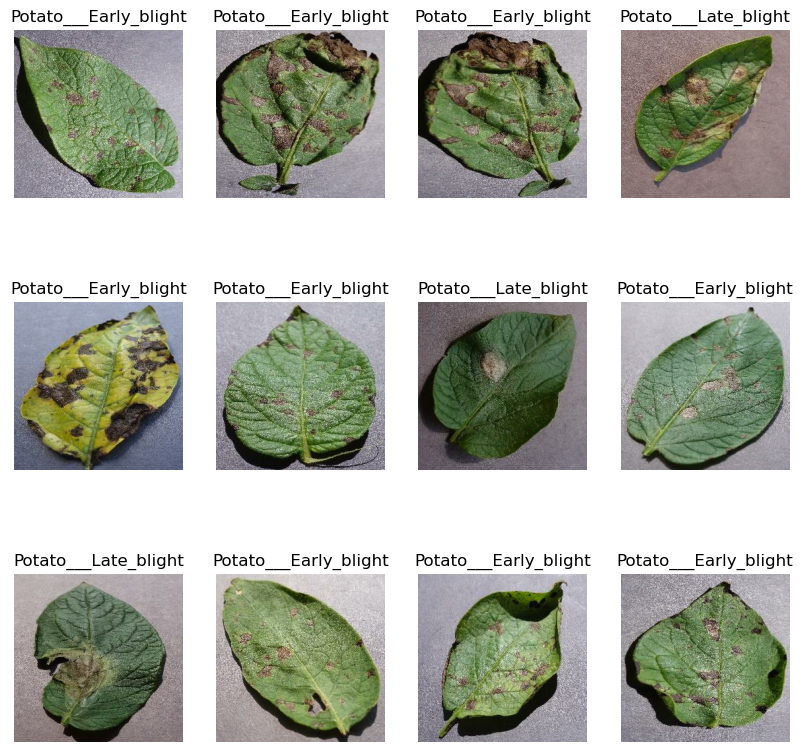

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
#Splitting the DATAset

In [18]:
len(dataset)

68

In [20]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [22]:
train_ds = dataset.take(54)
len(train_ds)

54

In [24]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [26]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [32]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

54

In [40]:
len(val_ds)

6

In [42]:
len(test_ds)

8

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
#Building the Model

In [50]:
#resize_and_rescale = tf.keras.Sequential([
#  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#  layers.experimental.preprocessing.Rescaling(1./255),
#])

#Experimental is not available now in latest versions of tensorflow. Therefore using a different approach

In [52]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [56]:
#DATA Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [58]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
#Compiling the Model

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [68]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 745ms/step - accuracy: 0.4583 - loss: 0.9589 - val_accuracy: 0.4375 - val_loss: 0.9185
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 884ms/step - accuracy: 0.6365 - loss: 0.7841 - val_accuracy: 0.6979 - val_loss: 0.7925
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 841ms/step - accuracy: 0.7769 - loss: 0.5280 - val_accuracy: 0.8177 - val_loss: 0.3794
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 721ms/step - accuracy: 0.8583 - loss: 0.3396 - val_accuracy: 0.8021 - val_loss: 0.4381
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 766ms/step - accuracy: 0.8791 - loss: 0.2843 - val_accuracy: 0.8646 - val_loss: 0.3154
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 783ms/step - accuracy: 0.8970 - loss: 0.2767 - val_accuracy: 0.9219 - val_loss: 0.2070
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 790ms/step - accuracy: 0.9123 - loss: 0.2241 - val_accuracy: 0.9062 - val_loss: 0.2264
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 804ms/step - accuracy: 0.9140 - loss: 0.2092 - val_accu

In [70]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.9768 - loss: 0.0553


In [72]:
scores

[0.07141309231519699, 0.96875]

In [74]:
history

In [76]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [78]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [80]:
type(history.history['loss'])

list

In [82]:
len(history.history['loss'])

50

In [84]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9025038480758667,
 0.6984930634498596,
 0.45245763659477234,
 0.37929221987724304,
 0.27957674860954285]

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

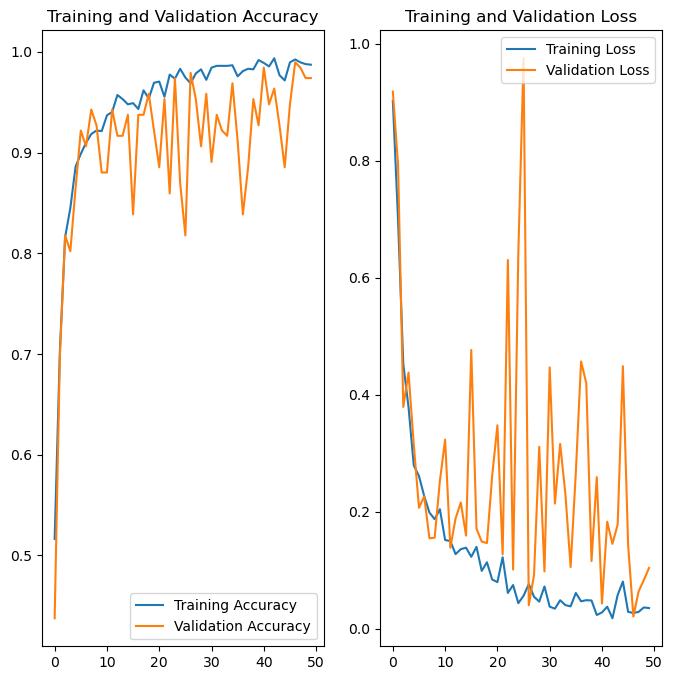

In [88]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
predicted label: Potato___Early_blight


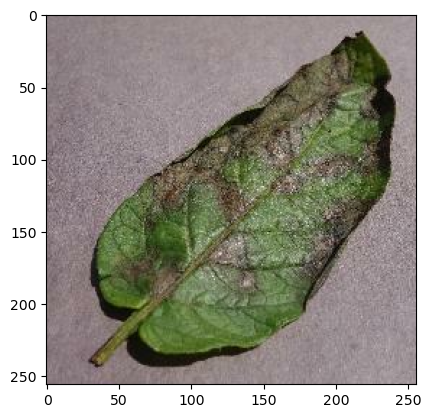

In [90]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2025-06-12 15:19:25.864355: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


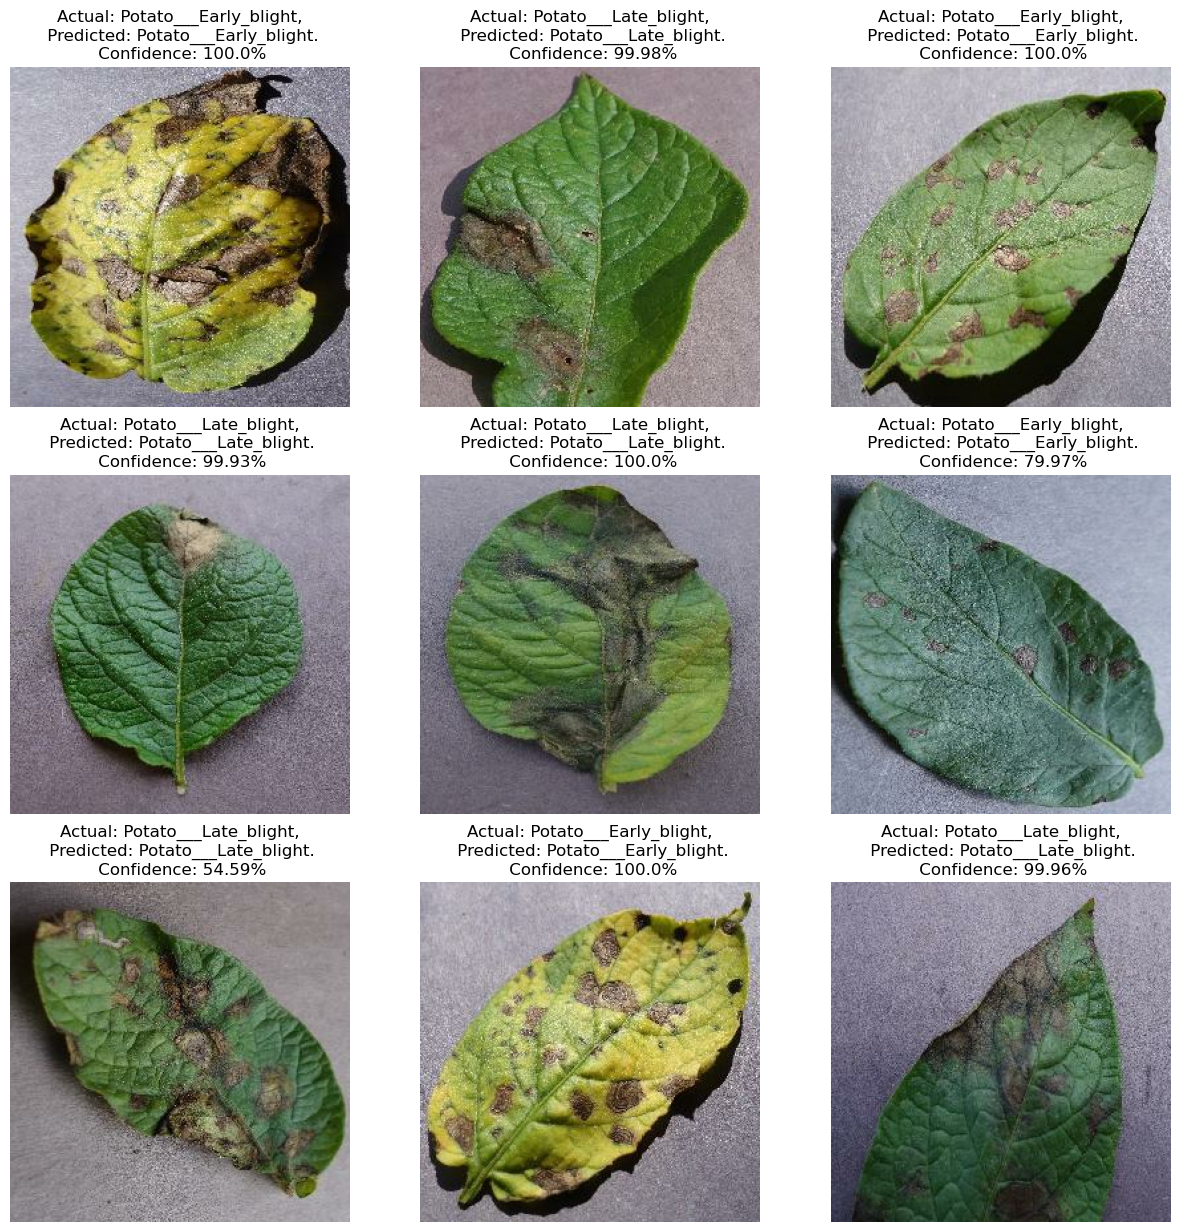

In [94]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [111]:
import os

model_dir = "/Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models"

# Filter only valid integer-named directories
existing_versions = [
    int(name) for name in os.listdir(model_dir)
    if name.isdigit()
]

model_version = max(existing_versions + [0]) + 1
save_path = os.path.join(model_dir, str(model_version))

# Export the model in SavedModel format (for TF Serving, TFLite, etc.)
model.export("/Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models")

INFO:tensorflow:Assets written to: /Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models/assets


INFO:tensorflow:Assets written to: /Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models/assets


Saved artifact at '/Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13423082384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13423083152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13423081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13423082000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13311213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13311214416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13311215376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13311214608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13423080848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13311215184: TensorSpec(shape=(), dtype=tf.resource,

In [114]:
model.save("/Users/devadeva/Desktop/MNIT/Machine Learning/Potato-Disease Classification/Models/potatoes.h5")

In [116]:
pip install tensorflow-serving-api

Note: you may need to restart the kernel to use updated packages.
